In [1]:
import oofempy
import util # some utility functions
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')
pv.start_xvfb()

problem = oofempy.linearStatic(nSteps=1, outFile="test_4.out")

# domain (if no engngModel specified to domain, it is asigned to the last one created)
domain = oofempy.domain(1, 1, problem, oofempy.domainType._2dPlaneStressMode, tstep_all=True, dofman_all=True, element_all=True)
problem.setDomain(1, domain, True)

In [2]:
ltf1 = oofempy.peakFunction(1, domain, t=1, f_t=1)
ltfs = (ltf1, )

# boundary conditions
# loadTimeFunction parameter can be specified as int value or as LoadTimeFunction itself (valid for all objects with giveNumber() method)
bc1   = oofempy.boundaryCondition(    1, domain, loadTimeFunction=1, dofs=(1,2), values=(0,0), set=1)
n2    = oofempy.nodalLoad(            2, domain, loadTimeFunction=1,    components=(0,-10.), dofs=(1,2), set=2)
bcs = (bc1, n2)

In [3]:
# material and cross section
mat = oofempy.isoLE(1, domain, d=1., E=30.e6, n=0.2, tAlpha=1.2e-5)
cs  = oofempy.simpleCS(1, domain, area=0.5, Iy=0.0, beamShearCoeff=1.e18, thick=0.5)

# nodes
# if one value is passed as parameter where oofem expects array of values, it must be passed as tuple or list (see load in n4)
nodes = []
nn=0
h=1
l=10
nelemh = 4
neleml = 10
for i in range(neleml):
    for j in range(nelemh):
        nn+=1
        nodes.append(oofempy.node(nn, domain, coords=(i*(l/neleml), j*(h/nelemh), 0.)))
# elements
elements=[]
ne=0
for i in range(neleml-1):
    for j in range(nelemh-1):
        ne+=1
        n1 = 1+i*nelemh+j
        n2 = n1+nelemh
        n3 = n2+1
        n4 = n1+1
        elements.append(oofempy.planeStress2d(ne, domain, nodes=(n1,n2,n3,n4), mat=1, crossSect=1))

s1 = oofempy.createSet(1, domain, nodes=tuple(range(1,nelemh+1))) 
s2 = oofempy.createSet(2, domain, nodes=tuple(range(neleml*(nelemh-1)+1, neleml*nelemh+1))) 

# setup domain
util.setupDomain (domain, nodes, elements, (cs,), (mat,), bcs, (), ltfs, (s1,s2))

In [4]:
print("\nSolving problem")
problem.checkProblemConsistency()
problem.init()
problem.postInitialize()

problem.setRenumberFlag()
problem.solveYourself()

problem.terminateAnalysis()
print("\nProblem solved")




Solving problem

Problem solved


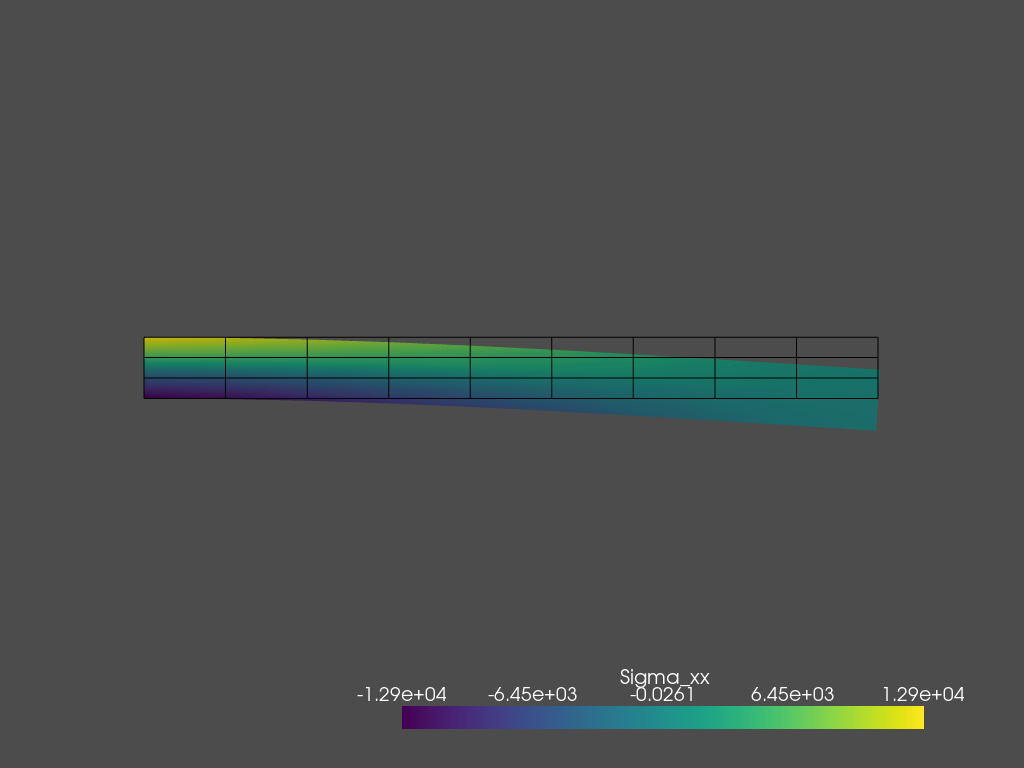

In [5]:
vtkxmlPy = oofempy.vtkmemory(1, problem, domain_all=True, tstep_all=True, dofman_all=True, element_all=True, vars=(1,4), primvars=(1,), cellvars = (47,), stype=1, pythonExport=1)
vtkxmlPy.initialize()
vtkxmlPy.doOutput(problem.giveCurrentStep(), False)
for p in vtkxmlPy.getVTKPieces():
    #print ("Piece:", p)
    #print(p.getVertices())
    #print(p.getCellConnectivity())
    #print(p.getCellTypes(vtkxmlPy))
    disp = p.getPrimaryVertexValues(oofempy.UnknownType.DisplacementVector)
    sig = p.getInternalVertexValues(oofempy.InternalStateType.IST_StressTensor)
    sigx = sig[:, 0]
    
    grid = pv.UnstructuredGrid(p.getCellConnectivity(), p.getCellTypes(vtkxmlPy), p.getVertices())
    grid.point_arrays['Sigma_xx'] = sigx
    grid['Disp'] = disp
    warped = grid.warp_by_vector('Disp', factor=10.)
    p = pv.Plotter()
    p.add_mesh(warped, scalars='Sigma_xx')
    p.add_mesh(grid, style='wireframe', color='black')
    p.set_viewup((0,1,0))
    p.show()
problem.terminateAnalysis()